# Principal Component Analysis of Clock Drawing

In this notebook, Principal Component Analysis (PCA) is used to perform dimensionality reduction on the RowanSOM Clock Drawing dataset.

First, import our tools.

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score

It is useful to keep track of which features are categorical, as PCA is not very helpful for categorical features.

In [2]:
categorical_cols = ['comm_DwgTotStrokes',
                    'copy_DwgTotStrokes_A',     
                    'ClockFace1TotStrokes',
                    'ClockFace1TotStrokes_A',
                    'CFNonCFTerminator',
                    '7.comm_HH1TotStrokes',
                    '7.copy_HH1TotStrokes',
                    '12.comm_MH1TotStrokes',
                    '12.copy_MH1TotStrokes',
                    'Digit1Strokes',
                    'Digit1Strokes_A',
                    'Digit2Strokes',
                    'Digit2Strokes_A',
                    'Digit3Strokes',
                    'Digit3Strokes_A',
                    'Digit4Strokes',
                    'Digit4Strokes_A',
                    'Digit5Strokes',
                    'Digit5Strokes_A',
                    'Digit6Strokes',
                    'Digit6Strokes_A',
                    'Digit7Strokes',
                    'Digit7Strokes_A',
                    'Digit8Strokes',
                    'Digit8Strokes_A',
                    'Digit9Strokes',
                    'Digit9Strokes_A',
                    'Digit10Strokes',
                    'Digit10Strokes_A',
                    'Digit11Strokes',
                    'Digit11Strokes_A',
                    'Digit12Strokes',
                    'Digit12Strokes_A',
                    'Digit1Outside',
                    'Digit1Outside_A',
                    'Digit2Outside',
                    'Digit2Outside_A',
                    'Digit3Outside',
                    'Digit3Outside_A',
                    'Digit4Outside',
                    'Digit4Outside_A',
                    'Digit5Outside',
                    'Digit5Outside_A',
                    'Digit6Outside',
                    'Digit6Outside_A',
                    'Digit7Outside',
                    'Digit7Outside_A',
                    'Digit8Outside',
                    'Digit8Outside_A',
                    'Digit9Outside',
                    'Digit9Outside_A',
                    'Digit10Outside',
                    'Digit10Outside_A',
                    'Digit11Outside',
                    'Digit11Outside_A',
                    'Digit12Outside',
                    'Digit12Outside_A',
                    'CenterDotStrokeNum',
                    'CenterDotStrokeNum_A',
                    'PreFirstHandNoNoiseInitiator',
                    'PreFirstHandNoNoiseInitiator_A',
                    'PreSecondHandNoNoiseInitiator',
                    'PreSecondHandNoNoiseInitiator_A',
                    'InterDigitIntervalCount',
                    'InterDigitIntervalCount_A',
                    'AnchorLatencyIntervalCount',
                    'AnchorLatencyIntervalCount_A']

print('Number of categorical features:', len(categorical_cols))

Number of categorical features: 67


We define a function to load our data.

In [3]:
def load_data(split=True):
    data = pd.read_csv('CombinedV2Filter.csv')
    
    
    if split:
        categorical = data[categorical_cols]
        continuous = data.drop(categorical_cols, axis=1)
        return categorical, continuous
    else:
        return data

Now, let's load our data. We want to take care to remove the column with our target data.

In [4]:
categorical, continuous = load_data()
continuous.drop(['dx_1'], axis=1, inplace=True)

print('Categorical subset shape:', categorical.shape)
print('Continuous subset shape:', continuous.shape)

Categorical subset shape: (196, 67)
Continuous subset shape: (196, 285)


We see that our categorical features have been split off from our continuous features. This is good, as we can apply PCA to the entire continuous subset.

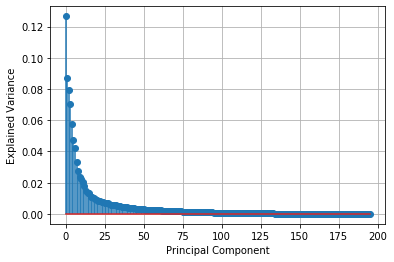

In [5]:
pca = PCA()
pca.fit(continuous)
plt.stem(pca.explained_variance_ratio_, use_line_collection=True)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.grid()
plt.show()

The above plot shows the percentage of total variance in the data explained by each principal component. Clearly, there is a large amount of variance information contained in the first several principal components. We can exploit this information to perform dimensionality reduction. 

In some applications, it is useful to use the extracted high-information principal components directly. However, in this setting we wish to know which features are the most important. Therefore, we wish to perform feature selection, instead of feature extraction.

To do this, we will first trim our principal components to only the first N such that we can explain 95% of the variance in the data.

Cumulative explained variance: 0.950027374745868


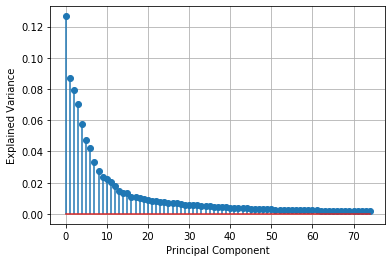

In [6]:
biggest = {'components': [],
           'explained_variance': []}
ev_sum = 0
for component, explained_variance in zip(pca.components_,
                                         pca.explained_variance_ratio_):
    biggest['components'].append(component)
    biggest['explained_variance'].append(explained_variance)
    ev_sum += explained_variance
    if ev_sum >= .95:
        print('Cumulative explained variance:', ev_sum)
        break
        
plt.stem(biggest['explained_variance'], use_line_collection=True)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.grid()
plt.show()

We have gone from 196 principal components to just 75, while retaining 95% of the information about the variance of the data.

Now that we have the principal components with the highest density, we can extract from them the features that were most important in their construction.

For each principal component, the absolute contribution of each feature is normalized, and any feature with a normalized principal axis greater than 0.5 is considered to be "important", and has its weight incremented by the explanatory fraction of its principal component.

In order to maintain a total of 100 selected features, we choose the 33 most heavily-weighted continuous features (to be selected along with the 67 categorical features).

In [7]:
indices = np.zeros(continuous.shape[1])
for component, weight in zip(biggest['components'], biggest['explained_variance']):
    normalized = MinMaxScaler().fit_transform(np.abs(component).reshape(-1, 1))
    indices[np.nonzero(normalized > 0.5)[0]] += weight

important_indices = np.argsort(indices)[-33:]

Now we can construct our final list of selected features. The important continuous features are printed below, and the categorical features are already known (see [2]).

In [8]:
important_indices = np.argsort(indices)[-33:]
features = list(continuous)
important_features = []
for i in important_indices:
    important_features.append(features[i])
selected_features = categorical_cols + important_features

print(important_features)

['Digit7DistCircum_A', 'Digit3Width', 'Digit10Width', '4.copy_ClockFace1EllipVSymm', 'Digit2DistCircum_A', 'Digit8DistCircum_A', 'copy_InkLenTimeCCQ2', 'Digit5DistCircum_A', 'Digit2Width', 'Digit6DistCircum_A', 'Digit1DistCircum_A', 'ClockFace1HorSymm_A', 'Digit9Width', 'Digit5Width', 'comm_InkLenTimeCCQ4', 'Digit12Width', 'Digit7DistCircum', 'Digit5CentY', 'Digit4CentY', 'Digit6CentY', 'Digit7CentY', 'Digit8CentY', 'Digit4CentX', 'Digit2CentX', 'Digit4CentX_A', 'Digit3CentX_A', 'Digit5CentX', 'Digit3CentX', 'Digit2CentX_A', 'Digit1CentX', 'Digit1CentX_A', 'CFnonCFterminator_A', 'CFNonCFNoNoiseTerminator']


Let's evaluate how impactful this dimensionality reduction is. First, let's load a clean copy of our data and split it into training and testing folds.

In [9]:
data = load_data(split=False)
targets = data.loc[:, 'dx_1']
data.drop(['dx_1'], axis=1, inplace=True)
x_train, x_test, y_train, y_test = tts(data, targets, test_size=0.3, random_state=42)

We will use XGBoost as a test classifier.

In [10]:
def make_xgb_classifier():
    return xgb.XGBClassifier(max_depth=10,
                             learning_rate=0.1,
                             n_estimators=1000,
                             objective='multi:softmax',
                             num_class=5,
                             n_jobs=-1)

clf = make_xgb_classifier()
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print('XGBClasifier performance on full dataset:', accuracy_score(y_test, predictions))

XGBClasifier performance on full dataset: 0.3559322033898305


On the full dataset with 352 features, the XGBoost classifier achieves an accuracy of 35.593%. This is somewhat impressive, as the dataset comprises 5 classes; a random guesser would achieve an accuracy of 20%.

Now, let's train an XGBoost classifier on the dataset with 100 features.

In [11]:
trimmed_data = data.loc[:, selected_features]
x_train_t, x_test_t, y_train_t, y_test_t = tts(trimmed_data, targets, test_size=0.3, random_state=42)

clf_t = make_xgb_classifier()

clf_t.fit(x_train_t, y_train_t)
predictions_t = clf_t.predict(x_test_t)
print('XGBClasifier performance on trimmed dataset:', accuracy_score(y_test_t, predictions_t))

XGBClasifier performance on trimmed dataset: 0.3898305084745763


We see that the performance on the trimmed dataset is 38.983%, 3.39 percent improvement. 